# Siparişler - `review_score` Çok Değişkenli Regresyonu

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

⚠️ Devam etmeden önce:
* 💾 Önceki ünitenin Siparişler çözümünü indirin
* 👥 `order_solution.py`'nin içeriğini `olist/order.py` dosyasına kopyalayıp yapıştırın

⚠️ `olist` havuzunuzda `order.py` dosyasındaki kod değişikliklerini commit etmeyi unutmayın!

👇 Öncelikle `orders` veri setini içeri aktarın

In [4]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.576110
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,851.495069
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22,514.410666
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20,1822.226336
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72,29.676625


Önceki analizimizi hatırlayalım:

Aşağıdaki 👇 korelasyon matrisi üzerinden, `review_score`'un çoğunlukla iki özellik ile ilişkili olduğunu görebiliriz: `wait_time` ve `delay_vs_expected`. Ancak, bu iki özellik de birbirleriyle yüksek oranda ilişkilidirler.

Bu alıştırmada, bir özelliğin etkisini ayırt etmek için `statsmodels` kullanacağız, **diğer özellikleri sabit tutarak**.

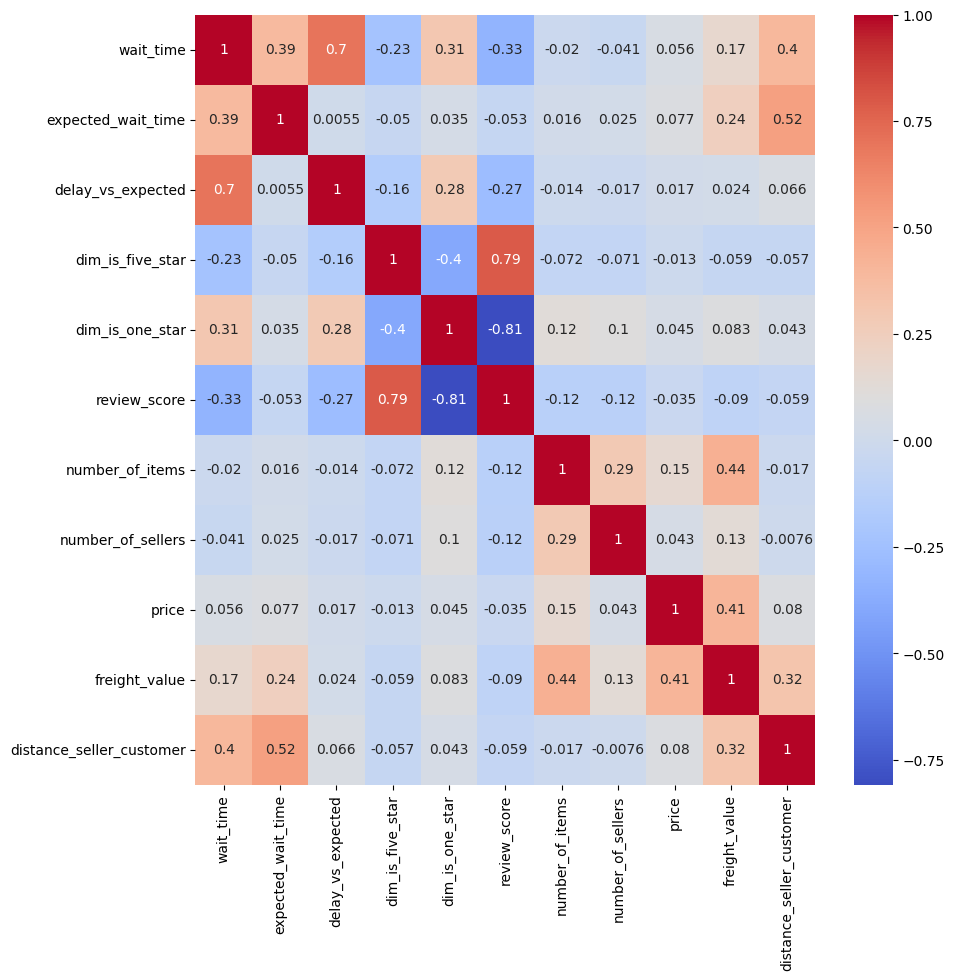

In [5]:
plt.figure(figsize = (10, 10))

sns.heatmap(
    orders.corr(numeric_only=True),
    cmap='coolwarm',
    annot=True,
    annot_kws={"size": 10}
);

## 1 - Tek Değişkenli Regresyon

❓ [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) ile `statsmodels.formula.api` kullanarak hızlı bir şekilde şunları oluşturun:
 - `model1`: `review_score`'un `wait_time` üzerinde ols regresyonu
 - `model2`: `review_score`'un `delay_vs_expected` üzerinde ols regresyonu

Her biri için `summary` tablosunu yazdırın ve sonuçları yorumlayin:
- Bu sonuçların seaborn regplot sonuçları ile nasıl eşleştiğini anladığınızdan emin olun
- Regresyon performans metriği `R-squared`, `individual regression coefficients`, `t-values`, `p-values` ve `95% confidence intervals`'ı okuyun

***Model 1***:

In [6]:
import statsmodels.formula.api as smf

# review_score'un wait_time üzerindeki etkisi
model = smf.ols(formula='wait_time ~ review_score', data=orders).fit()

#Sonuç özetini yazdır
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              wait_time   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Sun, 28 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:25:52   Log-Likelihood:            -3.4574e+05
No. Observations:               95872   AIC:                         6.915e+05
Df Residuals:                   95870   BIC:                         6.915e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.7259      0.097    233.282   

***Model 2***:

In [7]:
# review_score'un delay_vs_expected üzerindeki etkisi
model2 = smf.ols('review_score ~ delay_vs_expected', data=orders).fit()

# Sonuç özetini yazdır
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Sun, 28 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:26:02   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.00

## 2 - Çok Değişkenli Regresyon

❓ Siparişe bir gün `delay_vs_expected` eklemenin `review_score` üzerindeki etkisi nedir, **`wait_time` sabit tutarak**? İki özellikten hangisi düşük `review_score` için en açıklayıcıdır?

Bu amaçla, `wait_time` ve `delay_vs_expected`'in özellikler (bağımsız değişkenler) olduğu ve `review_score`'un hedef (bağımlı değişken) olduğu bir OLS modeli `model3`'ü çalıştırın

***Model 3***:

In [8]:
# Her iki değişkeni de formüle ekliyoruz
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Sun, 28 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:26:56   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.00

----
👉 Çok değişkenli regresyon, bir özelliğin etkisini izole etmek ve diğer özelliklerin etkisini kontrol etmek için bize izin verir. Bu yeni katsayılara **`kısmi korelasyon katsayıları`** denir. 

❓ Yukarıda *seaborn* ile hesaplanan **basit regresyon** katsayıları ile fark görebilir misiniz? 

❓ `wait_time` ve `delay_vs_expected` için göreceli eğimler hakkında ne söyleyebilirsiniz?

<details>
    <summary>- 💡 Solution 💡-</summary>

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`! This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors

---
❌ R-squared oldukça düşük: review_score varyasyonlarının en fazla %12'si `wait_time` ve `delay_vs_expected`'in birleşik varyasyonları tarafından açıklanır.

✅ Doğrusal regresyonun açıklanabilirliğini iyileştirmek için regresyonumuza daha fazla özellik eklemeyi deneyelim.

Sonraki adımlarda `orders` veri setinden daha fazla özellik içeren yeni bir OLS `model4` oluşturacağız. Adım adım size rehberlik edeceğiz.

📝 <u>Not</u>: bir **`Çok Değişkenli Doğrusal Regresyon`** aynı zamanda **`Ordinary Least Squares`** yöntemi olarak da adlandırılır çünkü bu modelde **`MSE Ortalama Kare Hatalar`**'ı minimize etmek istiyoruz

***Model 4***:

❓ Hangi özellikleri göz önünde almak istersiniz?

👉 Bu özelliklerle bir `features` DataFrame oluşturun.

- ⚠️ **veri sızıntısı** oluşturmayın: `review_score`'tan doğrudan türetilen özellikleri eklemeyin
- ⚠️ Birbirleriyle mükemmel bir şekilde ilişkili olan iki özellik eklemeyin

In [13]:
# 1. ADIM: Özellikleri Seçme (Doğru isimlerle)
feature_list = [
    'wait_time', 
    'delay_vs_expected', 
    'number_of_items',        # Düzelttik
    'number_of_sellers', 
    'price', 
    'freight_value',
    'distance_seller_customer'
]

features = orders[feature_list].copy()

# 2. ADIM: Standardizasyon (Z-score hesaplama)
# (Değer - Ortalama) / Standart Sapma
orders_standardized = (features - features.mean()) / features.std()

# 3. ADIM: review_score'u geri ekleme
# Modelin neyi tahmin edeceğini bilmesi için hedef değişkeni ekliyoruz
orders_standardized['review_score'] = orders['review_score']

# Sonucu kontrol edelim
print(orders_standardized.head())

   wait_time  delay_vs_expected  number_of_items  number_of_sellers     price  \
0  -0.431192          -0.161781        -0.264595          -0.112544 -0.513802   
1   0.134174          -0.161781        -0.264595          -0.112544 -0.086640   
2  -0.329907          -0.161781        -0.264595          -0.112544  0.111748   
3   0.073540          -0.161781        -0.264595          -0.112544 -0.441525   
4  -1.019535          -0.161781        -0.264595          -0.112544 -0.562388   

   freight_value  distance_seller_customer  review_score  
0      -0.652038                 -0.981488             4  
1       0.000467                  0.423668             4  
2      -0.164053                 -0.145002             5  
3       0.206815                  2.061317             5  
4      -0.652038                 -0.962761             5  


Sonra, özellikleri "standardize" edeceğiz.

**Bu ne anlama gelir?**

⚖️  Her özellik $X_i$'yi ilgili z-score'una $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ dönüştüreceğiz.

**Neden?**

Bir `çok değişkenli doğrusal regresyon`'da, her özelliğin hedef üzerindeki etkisini ölçmeye çalışıyoruz.
    
⚠️ Ölçek etkileri nedeniyle, bazı özellikler yanlışlıkla diğerlerinden daha önemli olarak görülecektir
    
> Örneğin: "yatak odası sayısı" özelliği 1 ile 5 arasında ve "yüzey" özelliği 20 ile 200 m² arasında ise, bu iki özelliğin aralıkları oldukça farklıdır...

Bu nedenle kısmi regresyon katsayıları $\beta_i$'yi birlikte karşılaştırabilmek için standardize ederiz. Aksi takdirde, $\beta_i$ aynı boyuta sahip olmayacak, yani elmalar (örn. "gün başına review-yıldızlar") ile portakalları (örn. "BRL başına review-yıldızlar") karşılaştırmış olacaksınız!

📅 Makine Öğrenmesi Algoritmalarını keşfettiğimizde, herhangi bir hedefi tahmin etmeye çalışmadan önce bazı ölçekleme işlemleri gerçekleştirmemiz gerekecektir.

👉  Özelliklerinizi standardize edin:

1. `features` DataFrame'inizden başlayın
1. `mean`'i çıkarın
1. Standart sapma `std`'ye bölün.
1. Sonucu `orders_standardized` değişkenine kaydedin.
1. Son olarak, `orders['review_score']` sütununu `orders_standardized`'e kopyalayın.

2. ve 3. adımları basit bir matematiksel işlem olarak yazabilirsiniz, hatta DataFrames ile de. Pandas bunu anlamak için yeterince akıllıdır.

<details>
  <summary><i>İpucu</i></summary>

  ```python
  features - features.mean() / features.std()
  ```

</details>

👉 `model4`'ü oluşturun ve eğitin.

In [ ]:
# MODEL 4: Tüm standardize edilmiş özelliklerle eğittim
# Formülü elle yazmak yerine feature_list'ten otomatik oluşturabiliriz
formula = "review_score ~ " + " + ".join(feature_list)

model4 = smf.ols(formula=formula, data=orders_standardized).fit()

# Sonuçları görelim
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Sun, 28 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:43:35   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

---
❓ En önemli özellikler nelerdir? (onları iyi görselleştirmek için `.plot(kind='barh')` ile bir çubuk grafik yapın)
- Genel regresyon performansı nasıl değişti?
- Bu regresyon istatistiksel olarak anlamlı mıdır?

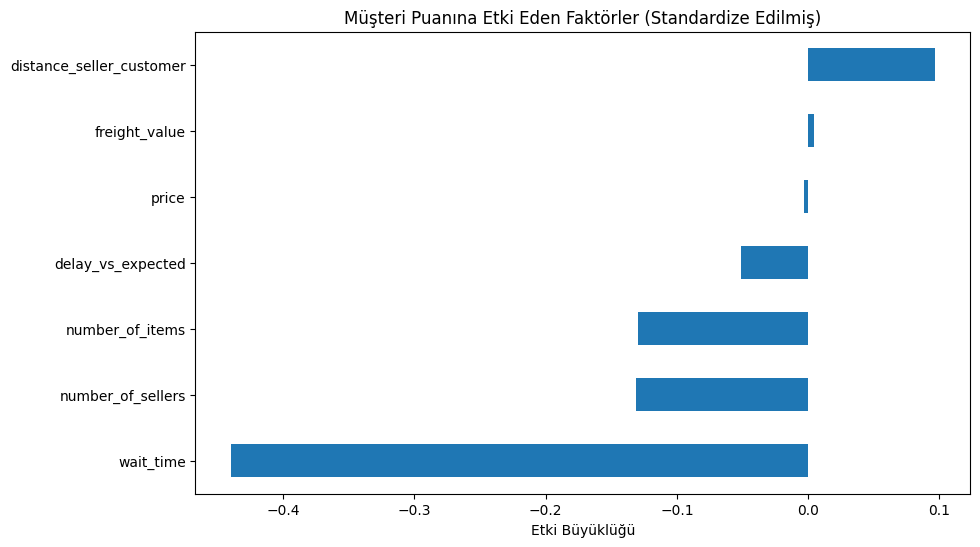

In [15]:
# Modelin katsayılarını alıyoruz
params = model4.params

# 'Intercept' (sabit terim) bir özellik olmadığı için grafikten çıkarıyoruz
params = params.drop('Intercept')

# Katsayıları büyüklüklerine göre sıralıyoruz
params = params.sort_values()

# Yatay çubuk grafik çiziyoruz (barh)
params.plot(kind='barh', figsize=(10, 6))

# (İsteğe bağlı) Grafik başlığı ekleyebilirsin
import matplotlib.pyplot as plt
plt.title("Müşteri Puanına Etki Eden Faktörler (Standardize Edilmiş)")
plt.xlabel("Etki Büyüklüğü")
plt.show()

<details>
    <summary>- 💡 Açıklamalar 💡 -</summary>
    

- `wait_time` en büyük açıklayıcı değişkendir
- Tek bir sipariş için ne kadar çok `items` ve `sellers` varsa, `review_score` o kadar düşük görünür
- Mesafe de müşteri memnuniyetinde rol oynar.
- Özellik seçiminize bağlı olarak, `price` ve `freight_value` hakkında p-değerleri çok yüksekse hiçbir sonuca varamayabilirsiniz
    
- Genel olarak, bu çok değişkenli regresyon, F-istatistiği 1'den çok daha büyük olduğu için istatistiksel olarak anlamlı kalır (en az bir özelliğin çok düşük p-değeri vardır)

- R-squared çok fazla artmadı. `review_score`'un açıklanabilirliğinin çoğu orders veri seti dışında yer alır.

⚠️ Gözlem sayısı (n) özellik sayısından (p) çok daha yüksek olduğunda düşük R-squared yaygındır. Böyle regresyonlardan, istatistiksel olarak anlamlı olması koşuluyla yine de ilgili içgörüler elde edilebilir.
</details>



## 3 - Model Performansını Kontrol Edin

⚠️ Regresyon performansı sadece R-squared'i ile ölçülmemelidir!

👀 Her zaman tahminlerin dağılımını, özellikle de kalıntıları görselleştirin.

❓ Kalıntıları hesaplayın.

Kalıntıların ortalamasının 0'a eşit olduğunu görmelisiniz (doğrusal regresyon yapılırken bunu her zaman doğrulayın)

In [17]:
# Kalıntıları (Hataları) alıyoruz: Gerçek Değer - Tahmin Edilen Değer
residuals = model4.resid

# Ortalamanın 0'a çok yakın olup olmadığını kontrol ediyoruz
print(f"Kalıntıların Ortalaması: {residuals.mean()}") 
# Sonuç 0.00000... gibi çok küçük bir sayı çıkmalı.

Kalıntıların Ortalaması: 4.579223812185698e-13


🧮 İlişkili RMSE'yi hesaplayın.

In [18]:
import numpy as np

# RMSE Formülü: Karekök(Ortalama(Hataların Karesi))
rmse = np.sqrt((residuals**2).mean())

print(f"RMSE: {rmse}")

RMSE: 1.1883112206210116


📊 `residuals`'ı bir histogramda çizin.

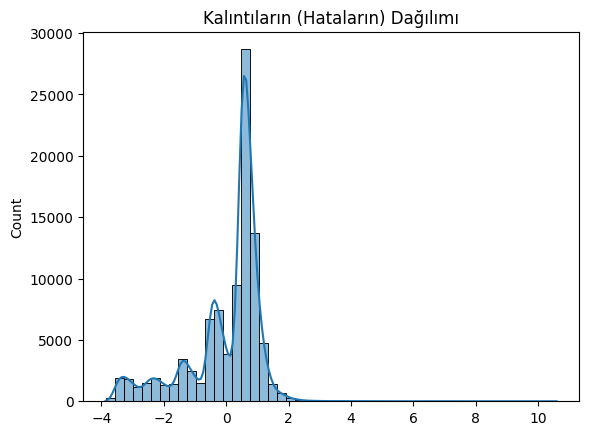

In [19]:
import seaborn as sns

# Hataların dağılım grafiği
sns.histplot(residuals, kde=True, bins=50)
plt.title("Kalıntıların (Hataların) Dağılımı")
plt.show()

❓ Kalıntıların distplot'unun neden bu kadar garip bir şekle sahip olduğunu tahmin edebilir misiniz?

*İpucu:*<br/>
👉 Aynı grafik üzerinde hem `review_score`'un dağılımını hem de `predicted_review_score`'un dağılımını çizin.

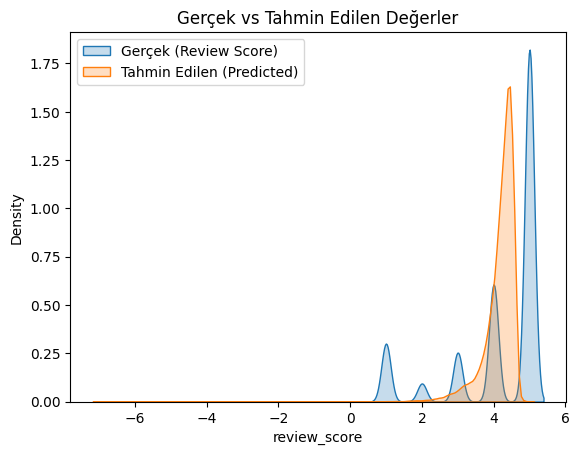

In [20]:
# Gerçek değerler (review_score) ile Tahmin edilen değerlerin dağılımını karşılaştırma
sns.kdeplot(orders_standardized['review_score'], label='Gerçek (Review Score)', fill=True)
sns.kdeplot(model4.predict(orders_standardized), label='Tahmin Edilen (Predicted)', fill=True)

plt.legend()
plt.title("Gerçek vs Tahmin Edilen Değerler")
plt.show()

📈 Aslında, önceki zorlukta `review_score`'un `delay_vs_expected`'e karşı `regresyon çizgisi`'ni zaten çizmiştik.

Bu çizimi yeniden görselleştirmek için aşağıdaki hücreyi çalıştırın:

(0.0, 5.937790427071895)

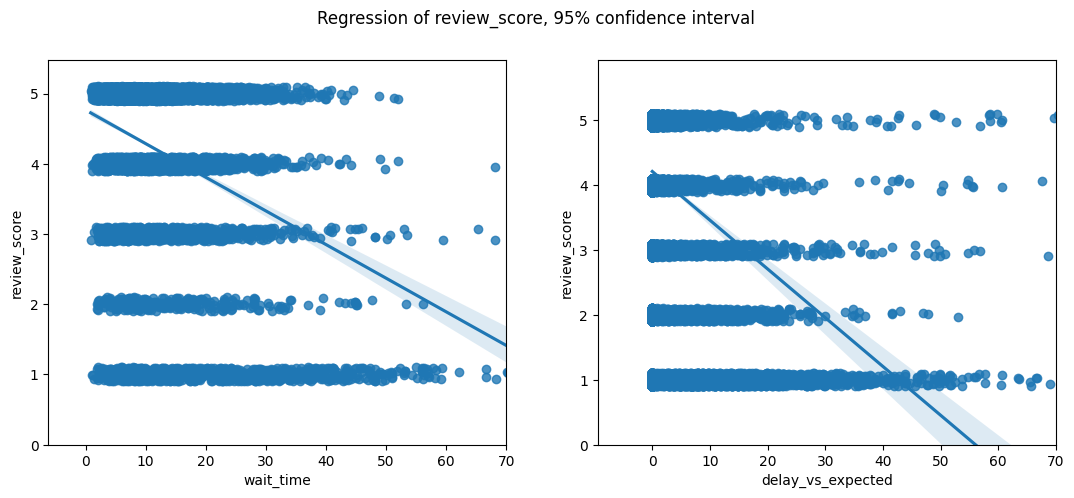

In [21]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

☝️ Bir siparişin `review_score`'unu onun `wait_time` veya `delay_vs_expected`'ine karşı regrese etmenin zor olduğunu görebilirsiniz çünkü `review_score` ayrı bir sayı olup aynı zamanda bir kategori olarak da yorumlanabilir: 1 (çok kötü), 2 (kötü), 3 (orta), 4 (iyi), 5 (mükemmel).

📅 Sonraki ünitede, adına rağmen bir `Classification Algorithm` olan yeni bir model keşfedeceksiniz: `Logistic Regression` 

☝️ Sonuç olarak, modelimiz iki nedenden dolayı o kadar harika değil:
- İlk olarak, review_scores'un önemli bir kısmını açıklamak için yeterli özelliğimiz olmadığı için (düşük R-squared)
- İkinci olarak, "doğrusal regresyon" işlevini ayrı bir sınıflandırma problemine uydurmaya çalıştığımız için

💡 Bireysel siparişler üzerinde çalışmak ve `wait_time` tabanlı ayrı `review_score`'ları açıklamaya çalışmak yerine, bir sonraki zorlukta siparişleri satıcılar tarafından toplayarak analiz edilmesini satıcı seviyesine yoğunlaştıracağız.

🏁 Harika iş!

💾 İşiniz bittiğinde bu not defterini *kaydetmeyi*, *commit* ve *push* etmeyi unutmayın!